# Plot Halo Mergers
Nithun Selva, July 2025

This notebook assumes that you have the output from `run_Anna_startrace.ipynb` available.

### Import

In [1]:
%matplotlib inline
import os
import socket
hostname = socket.gethostname()
if 'emu' in hostname:
    os.environ['TANGOS_SIMULATION_FOLDER'] = '/home/ns1917/tangos_sims/storm.4096g5HbwK1BH_bn/'
    # os.environ['TANGOS_DB_CONNECTION'] = '/home/ns1917/Databases/Marvel_BN_N10.db'
    os.environ['TANGOS_DB_CONNECTION'] = '/home/ns1917/pynbody/Tangos/Marvel_BN_N10.db'
    os.chdir('/home/ns1917/pynbody/AnnaWright_startrace/')
else: # grinnell
    os.environ['TANGOS_SIMULATION_FOLDER'] = '/home/selvani/MAP/Sims/cptmarvel.cosmo25cmb/cptmarvel.cosmo25cmb.4096g5HbwK1BH/'
    # os.environ['TANGOS_DB_CONNECTION'] = '/home/selvani/MAP/Data/Marvel_BN_N10.db'
    os.environ['TANGOS_DB_CONNECTION'] = '/home/selvani/MAP/pynbody/Tangos/Marvel_BN_N10.db'
    os.chdir('/home/selvani/MAP/pynbody/AnnaWright_startrace/')

import pynbody
import numpy as np
import h5py
import math
import tangos as db
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import glob
from pynbody.array import SimArray
import pandas as pd
import tqdm.auto as tqdm

In [2]:
# Simulation name and path
if 'emu' in hostname:
    simpath = '/home/ns1917/tangos_sims/'
    outfile_dir = "/home/ns1917/pynbody/stellarhalo_trace_aw/"
else:
    simpath = '/home/selvani/MAP/Sims/cptmarvel.cosmo25cmb/cptmarvel.cosmo25cmb.4096g5HbwK1BH/'
    outfile_dir = "/home/selvani/MAP/pynbody/stellarhalo_trace_aw/"

# basename = 'cptmarvel.cosmo25cmb.4096g5HbwK1BH'
# basename = 'rogue.cosmo25cmb.4096g5HbwK1BH'
basename = 'storm.cosmo25cmb.4096g5HbwK1BH'
# ss_dir = 'cptmarvel.4096g5HbwK1BH_bn'#'snapshots_200crit_h329' # same as db_sim?
# ss_dir = 'rogue.4096g5HbwK1BH_bn'
ss_dir = 'storm.4096g5HbwK1BH_bn'
sim_base = simpath + ss_dir + '/'
ss_z0 = sim_base + basename + '.004096'

In [3]:
timestep = db.get_timestep(ss_dir+'/%'+str(4096))
all_halos = timestep.halos.all()
print("There are %d halos in the snapshot." % len(all_halos))

# Filter for halos with stars
halos_with_stars = [h for h in all_halos if h.NStar > 0 and h['Mvir'] > 1e9]
for halo in halos_with_stars:
    print("Halo ID: %s, Mass: %1.2eM☉, Stars: %d" % (halo.halo_number, halo['Mvir'], halo.NStar))

There are 31851 halos in the snapshot.
Halo ID: 1, Mass: 6.41e+10M☉, Stars: 2854124
Halo ID: 2, Mass: 3.25e+10M☉, Stars: 581636
Halo ID: 3, Mass: 2.12e+10M☉, Stars: 143680
Halo ID: 4, Mass: 1.42e+10M☉, Stars: 225480
Halo ID: 5, Mass: 8.38e+09M☉, Stars: 49882
Halo ID: 6, Mass: 7.68e+09M☉, Stars: 20212
Halo ID: 7, Mass: 7.32e+09M☉, Stars: 65167
Halo ID: 8, Mass: 6.97e+09M☉, Stars: 62251
Halo ID: 10, Mass: 6.34e+09M☉, Stars: 2032
Halo ID: 11, Mass: 4.92e+09M☉, Stars: 3257
Halo ID: 13, Mass: 4.78e+09M☉, Stars: 10030
Halo ID: 14, Mass: 3.00e+09M☉, Stars: 5615
Halo ID: 15, Mass: 2.69e+09M☉, Stars: 3
Halo ID: 16, Mass: 2.59e+09M☉, Stars: 1949
Halo ID: 17, Mass: 2.63e+09M☉, Stars: 430
Halo ID: 20, Mass: 8.96e+09M☉, Stars: 14754
Halo ID: 22, Mass: 8.85e+09M☉, Stars: 1081
Halo ID: 23, Mass: 1.63e+09M☉, Stars: 79
Halo ID: 24, Mass: 1.53e+09M☉, Stars: 1470
Halo ID: 28, Mass: 1.21e+09M☉, Stars: 4
Halo ID: 39, Mass: 4.21e+09M☉, Stars: 494
Halo ID: 72, Mass: 2.41e+09M☉, Stars: 511


In [4]:
# Read in data from Anna's pipeline
with h5py.File(outfile_dir+'/'+basename+'_allhalostardata.h5','r') as f:
    hostids = f['host_IDs'].asstr()[:] # unique host IDs
    partids = f['particle_IDs'][:] # iords
    pct = f['particle_creation_times'][:] # formation times
    ph = f['particle_hosts'][:] # local host IDs (i.e., host at formation time)
    pp = f['particle_positions'][:] # position at formation time
    tsloc = f['timestep_location'][:] # snapshot where star particle first appears
uIDs = np.unique(hostids)

In [5]:
halo_particle_dict = {} # map iords to their unique host IDs
for i, part in enumerate(partids):
    halo_particle_dict[part] = hostids[i]

In [6]:
hostids

array(['4096_7', '4096_7', '4096_1', ..., '2304_14', '2304_14', '4096_1'],
      dtype=object)

In [7]:
uIDs

array(['0000_0', '0192_25', '0192_38', '0288_46', '0288_82', '0288_95',
       '0384_39', '0384_47', '0384_68', '0480_15', '0480_19', '0480_43',
       '0480_45', '0480_61', '0576_14', '0576_23', '0672_112', '0672_27',
       '0672_30', '0672_35', '0672_9', '0768_63', '0864_26', '0864_90',
       '0960_758', '0960_8', '1056_27', '1056_364', '1152_26', '1344_29',
       '1440_25', '1440_49', '1536_25', '1632_6', '1728_3', '1728_93',
       '1824_143', '2112_11', '2304_133', '2304_14', '2400_28', '2400_29',
       '2496_127', '2496_224', '2496_61', '2592_193', '2592_240',
       '2592_966', '2688_47', '2976_36', '3168_138', '3168_27', '3264_53',
       '3456_270', '3456_56', '3552_300', '3648_85', '3648_90', '3744_13',
       '4032_287', '4096_1', '4096_10', '4096_11', '4096_124', '4096_13',
       '4096_14', '4096_16', '4096_192', '4096_2', '4096_20', '4096_208',
       '4096_218', '4096_22', '4096_23', '4096_24', '4096_253', '4096_28',
       '4096_292', '4096_3', '4096_34', '4096_35',

In [8]:
all_timesteps = db.get_simulation(ss_dir).timesteps
halos_stars_dict = {}
for timestep in all_timesteps:
    # Get all halos in the current timestep with stars
    # Kinda overkill, since we only need ones at 4096 for now
    print('Processing timestep:', timestep.extension[-6:])
    halos_stars_dict[timestep.extension[-6:]] = [h for h in timestep.halos.all() if h.NStar > 0]

Processing timestep: 000192
Processing timestep: 000288
Processing timestep: 000384
Processing timestep: 000480
Processing timestep: 000576
Processing timestep: 000672
Processing timestep: 000768
Processing timestep: 000864
Processing timestep: 000960
Processing timestep: 001056
Processing timestep: 001152
Processing timestep: 001248
Processing timestep: 001344
Processing timestep: 001440
Processing timestep: 001536
Processing timestep: 001632
Processing timestep: 001728
Processing timestep: 001824
Processing timestep: 001920
Processing timestep: 002016
Processing timestep: 002112
Processing timestep: 002208
Processing timestep: 002304
Processing timestep: 002400
Processing timestep: 002496
Processing timestep: 002592
Processing timestep: 002688
Processing timestep: 002784
Processing timestep: 002880
Processing timestep: 002976
Processing timestep: 003072
Processing timestep: 003168
Processing timestep: 003264
Processing timestep: 003360
Processing timestep: 003456
Processing timestep:

### Loop

In [9]:
halos_stars_dict['004096']

[<Halo 'storm.4096g5HbwK1BH_bn/storm.cosmo25cmb.4096g5HbwK1BH.004096/halo_1' | NDM=11956794 Nstar=2854124 Ngas=5544225>,
 <Halo 'storm.4096g5HbwK1BH_bn/storm.cosmo25cmb.4096g5HbwK1BH.004096/halo_2' | NDM=6020296 Nstar=581636 Ngas=3055754>,
 <Halo 'storm.4096g5HbwK1BH_bn/storm.cosmo25cmb.4096g5HbwK1BH.004096/halo_3' | NDM=4023224 Nstar=143680 Ngas=1610867>,
 <Halo 'storm.4096g5HbwK1BH_bn/storm.cosmo25cmb.4096g5HbwK1BH.004096/halo_4' | NDM=2840249 Nstar=225480 Ngas=364281>,
 <Halo 'storm.4096g5HbwK1BH_bn/storm.cosmo25cmb.4096g5HbwK1BH.004096/halo_5' | NDM=1674684 Nstar=49882 Ngas=222673>,
 <Halo 'storm.4096g5HbwK1BH_bn/storm.cosmo25cmb.4096g5HbwK1BH.004096/halo_6' | NDM=1521044 Nstar=20212 Ngas=279119>,
 <Halo 'storm.4096g5HbwK1BH_bn/storm.cosmo25cmb.4096g5HbwK1BH.004096/halo_7' | NDM=1473366 Nstar=65167 Ngas=139001>,
 <Halo 'storm.4096g5HbwK1BH_bn/storm.cosmo25cmb.4096g5HbwK1BH.004096/halo_8' | NDM=1407596 Nstar=62251 Ngas=115365>,
 <Halo 'storm.4096g5HbwK1BH_bn/storm.cosmo25cmb.4096g5H

In [10]:
num = 1

In [11]:
halo = halos_stars_dict['004096'][num]
halo_numbers, dbids = halo.calculate_for_progenitors("halo_number()", "dbid()")
snapshots = [db.get_halo(dbid).timestep.extension[-6:] for dbid in dbids]
halo_snapshots_dict = {snapshot: halo_number for snapshot, halo_number in zip(snapshots, dbids)}

In [12]:
db.get_halo(halo_snapshots_dict['004096'])

<Halo 'storm.4096g5HbwK1BH_bn/storm.cosmo25cmb.4096g5HbwK1BH.004096/halo_2' | NDM=6020296 Nstar=581636 Ngas=3055754>

In [13]:
print(halo.timestep.extension[-6:], halo.halo_number)

004096 2


In [14]:
def plot_halo_mergers(sp,mask,haloids,color_map,timestep,rad=None,savepath=None):
    """Plots stellar positions from a simulation in three 2D projections.

    This function generates a 1x3 matplotlib figure showing XY, YZ, and XZ
    scatter plots of star particle positions. Particles are colored based on
    their unique host halo ID. The function includes an optional legend and
    can save the figure to a file.

    Args:
        sp (pynbody.snapshot.SimSnap): 
            The pynbody snapshot or sub-snapshot containing the particle data.
        mask (array): 
            A boolean mask or array of indices used to select the desired 
            star particles from `sp`.
        haloids (array): 
            A list of original host halo IDs, corresponding to the particles 
            selected by `mask`.
        color_map (dict): 
            A dictionary mapping each unique halo ID from `haloids` to a 
            matplotlib color.
        timestep (str or int): 
            The identifier for the current timestep, used in the main figure title.
        rad (float, optional): 
            The radius for the plot limits. If provided, the x and y axes for 
            each projection are set to `[-rad, rad]`. Defaults to None.
        savepath (str, optional): 
            The file path to save the generated plot. If None, the plot is 
            only displayed. Defaults to None.
            
    Returns:
        None
    """
    # Create an array of colors for each star particle
    particle_colors = [color_map[hid] for hid in haloids]
    # Create the scatter plot
    fig, axes = plt.subplots(1, 3, figsize=(54, 18))
    # Define projections
    projections = [
        {'ax': axes[0], 'dims': [0, 1], 'labels': ['x (kpc)', 'y (kpc)'], 'title': 'X-Y Projection'},
        {'ax': axes[1], 'dims': [1, 2], 'labels': ['y (kpc)', 'z (kpc)'], 'title': 'Y-Z Projection'},
        {'ax': axes[2], 'dims': [0, 2], 'labels': ['x (kpc)', 'z (kpc)'], 'title': 'X-Z Projection'}
    ]

    pos_data = sp.s['pos'][mask]

    for proj in projections:
        ax = proj['ax']
        dim1 = proj['dims'][0]
        dim2 = proj['dims'][1]

        ax.scatter(
            pos_data[:, dim1], 
            pos_data[:, dim2],
            c=particle_colors,
            s=25.0,  # Marker size
            alpha=0.25, # Use transparency to see overlapping structures
            edgecolors='none' # Remove marker edges for a cleaner look
        )

        ax.set_title(proj['title'], fontsize=14)
        ax.set_xlabel(proj['labels'][0], fontsize=12)
        ax.set_ylabel(proj['labels'][1], fontsize=12)

        if rad:
            ax.set_xlim(-rad, rad)
            ax.set_ylim(-rad, rad)

    # Display the legend
    legend_patches = [mpatches.Patch(color=color_map[hid], label=hid) for hid in np.unique(haloids)]
    if len(legend_patches) <= 20:
        axes[0].legend(handles=legend_patches, title="Original Halo ID", loc='upper right', fontsize=8)
    else:
        print(f"Warning: {len(legend_patches)} unique halos found. Legend will not be displayed to avoid clutter.")

    fig.suptitle(f"Snapshot {timestep}", fontsize=18, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    if savepath:
        print(f"Saving plot to {savepath}")
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

In [15]:
def make_colormap(unique_haloids):
    """Creates a color map for the unique halo IDs.

    Args:
        unique_haloids (array): A list of unique halo IDs.

    Returns:
        dict: A dictionary mapping halo IDs to their corresponding colors.
    """
    if len(unique_haloids) <= 10:
        colors = plt.cm.get_cmap('Accent', len(unique_haloids))
    else:
        # For more than 10 halos, 'viridis' or 'plasma' can work, though colors may be less distinct
        colors = plt.cm.get_cmap('viridis', len(unique_haloids))

    color_map = {hid: colors(i) for i, hid in enumerate(unique_haloids)}
    return color_map

In [16]:
# Since we center the plot on shrink_center, test for its existence
#! Halo 1025 cpt marvel is missing this
all_timesteps = db.get_simulation(ss_dir).timesteps
for timestep in all_timesteps:
    halo2 = timestep.halos.all()[1]
    try:
        halo2['shrink_center']
    except:
        print(timestep.extension[-6:])#, 'does not have shrink_center')
        # print(halo2.all_properties)
        # print()

000960
001056
001152
001248
001344
001440
001536
001632
001728
001824
001920
002016
002112
002208
002304
002400
002496
002592
002688
002784
002880
002976
003072
003168
003264
003360
003456
003552
003648
003744
003840
003936
004032
004096


Saving plots to /home/ns1917/pynbody/stellarhalo_trace_aw/merge_plots/storm.4096g5HbwK1BH_bn2


  0%|          | 0/42 [00:00<?, ?it/s]

Now on 004096
['4096_14' '2304_133' '1728_93' '0576_14' '2496_224' '0384_68' '0672_35'
 '0672_112' '4096_8' '2304_14' '3552_300' '4096_50' '4096_124' '0384_39'
 '0672_9' '4096_192' '4096_7' '3648_90' '4096_3' '0672_27' '0576_23'
 '4096_11' '2592_193' '1728_3' '4096_16' '4096_208' '4096_13' '1056_364'
 '2688_47' '4096_23' '0288_46' '3648_85' '4096_10' '4096_72' '2592_966'
 '0864_26' '1440_49' '4096_35' '3264_53' '4096_1' '0960_758' '1632_6'
 '4096_6' '4096_34' '0960_8' '0480_15' '1152_26' '4096_218' '4096_2'
 '1440_25' '0000_0' '0864_90' '3456_56' '0384_47' '0480_61' '0288_95'
 '2976_36' '4096_43' '0672_30' '2496_61' '0288_82' '0768_63' '2112_11'
 '1344_29' '0192_25' '0480_43' '0480_45' '4096_39' '4096_253' '4096_49'
 '2400_28' '0480_19' '3744_13' '4096_5' '1056_27' '4096_47' '4096_60'
 '3456_270' '3168_138' '0192_38' '2496_127' '4096_28' '4096_24' '3168_27'
 '1824_143' '4096_20' '4096_22' '1536_25' '2400_29' '2592_240' '4096_4'
 '4096_292' '4032_287']
No shrink center on 004096


/tmp/ipykernel_2946823/168769269.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_haloids))


Calculated shrink center: [1299.67419656 3401.62400681 -117.35725383]
Num stars: 581636, Masked num stars: 581634
Saving plot to /home/ns1917/pynbody/stellarhalo_trace_aw/merge_plots/storm.4096g5HbwK1BH_bn2/storm.4096g5HbwK1BH_bn_2_004096.png


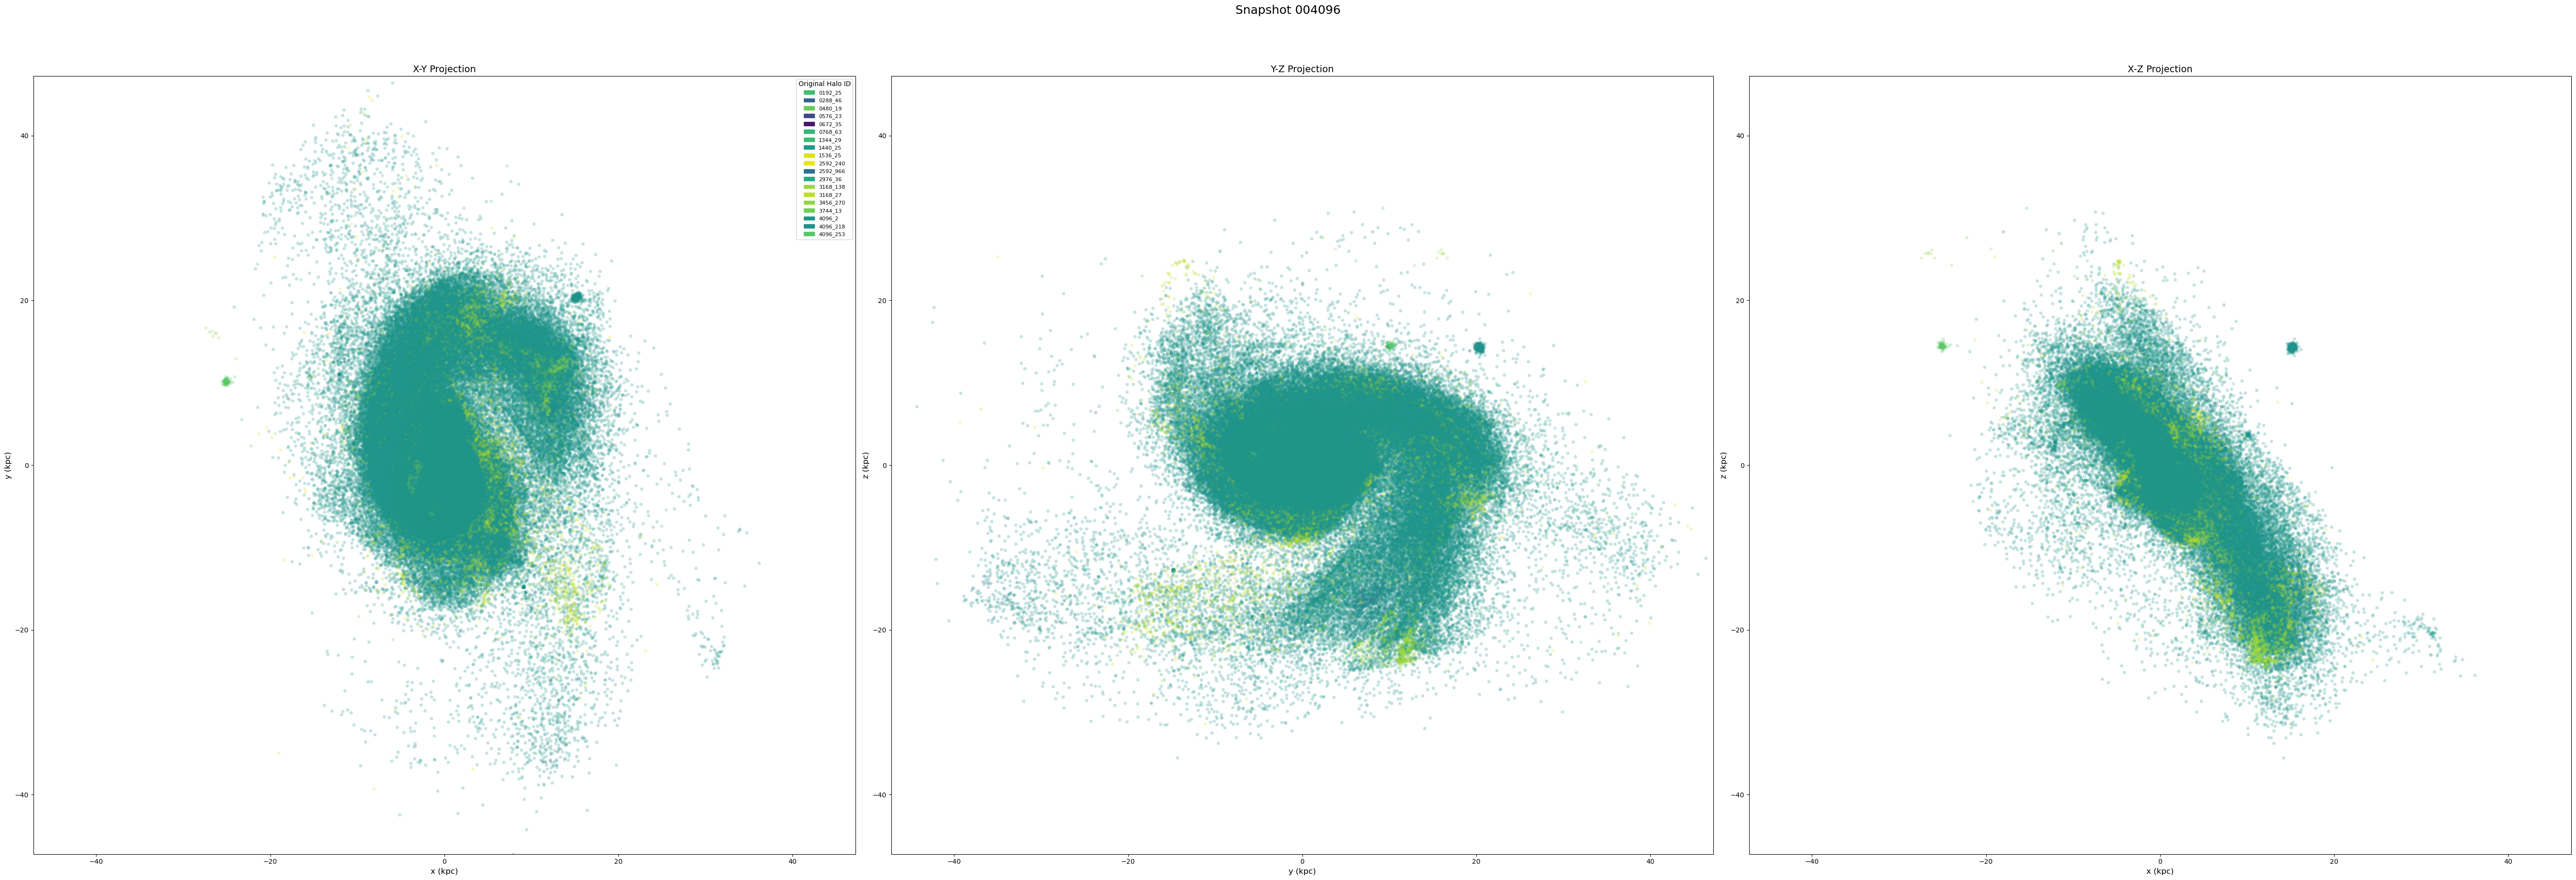

Saving plot to /home/ns1917/pynbody/stellarhalo_trace_aw/merge_plots/storm.4096g5HbwK1BH_bn2zoom/storm.4096g5HbwK1BH_bn_2_004096.png


In [ ]:
halo = halos_stars_dict[all_timesteps[-1].extension[-6:]][num]

# Make a dict of the halo's id at each timestep
halo_numbers, dbids = halo.calculate_for_progenitors("halo_number()", "dbid()")
snapshots = [db.get_halo(dbid).timestep.extension[-6:] for dbid in dbids]
halo_snapshots_dict = {snapshot: dbid for snapshot, dbid in zip(snapshots, dbids)}

# Save paths for the plot
overwrite = False
save_bases = [os.path.join(outfile_dir, 'merge_plots', ss_dir+str(halo.halo_number)),
              os.path.join(outfile_dir, 'merge_plots', ss_dir+str(halo.halo_number)+'zoom' ),
              os.path.join(outfile_dir, 'merge_plots', ss_dir+str(halo.halo_number)+'morezoom')]
print(f"Saving plots to {save_bases[0]}")
for save_base in save_bases:
    if not os.path.exists(save_base):
        os.makedirs(save_base)
filename_base = ss_dir + '_' + str(halo.halo_number) + '_'

# Loop through all timesteps for this halo
pbar = tqdm.tqdm(total=len(all_timesteps))
for i, timestep in enumerate(all_timesteps[::-1]):
    timestep = timestep.extension[-6:]

    # Get simulation and halo
    s = pynbody.load(sim_base + basename + '.' + timestep)
    s.physical_units()
    halo = db.get_halo(halo_snapshots_dict[timestep])
    print("Now on", timestep)

    save_path = os.path.join(save_bases[0], filename_base + timestep + '.png')
    save_path2 = os.path.join(save_bases[1], filename_base + timestep + '.png')
    save_path3 = os.path.join(save_bases[2], filename_base + timestep + '.png')

    # First timestep
    if i == 0:
        #! NOT USING Reproduce unique color map seed
        rng = np.random.default_rng(num) 
        uIDs_shuffled = rng.permutation(uIDs)
        print(uIDs_shuffled)
        colormap = make_colormap(uIDs_shuffled)

        # Universal scaling plot to z=0 value
        try:
            rad = halo['Rvir']
        except:
            rad = halo['max_radius']
            
    if not overwrite and (os.path.isfile(save_path) and os.path.isfile(save_path2) and os.path.isfile(save_path3)):
        print(f"File {save_path} already exists, skipping...")
        pbar.update(1)
        continue

    # Center on halo
    try:
        # Use existing value from tangos
        roughcen = halo['shrink_center']
    except:
        try:
            # Try calculating from pynbody
            print('No shrink center on', timestep)
            h = s.halos(halo_numbers='v1')
            roughcen = pynbody.analysis.halo.shrink_sphere_center(h[halo.halo_number])
            print('Calculated shrink center:', roughcen)
        except:
            print('Failed again, skipping...')
            pbar.update(1)
            continue

    # Radius for adaptive zoom plots
    try:
        currad = halo['Rvir']
    except:
        currad = halo['max_radius']

    # Filter snapshot by only particles in the virial radius, center on halo
    sp = s[pynbody.filt.Sphere(SimArray([rad], "kpc"), roughcen)].load_copy()
    sp.physical_units()
    sp['pos'] -= roughcen
    print("Num stars: "+str(len(sp.s)), end=', ') # num of stars

    # mask = np.where(sp.s['amiga.grp'] == halo.halo_number)[0]
    # mask = np.where(sp.s['amiga.grp'] == sp.s['amiga.grp'])[0] # dummy to ignore mask
    mask = sp.s['tform'] > 0 # Exclude wind particles: FROM ANNA'S CODE
    haloids = np.array([halo_particle_dict[part] for part in sp.s['iord'][mask]])
    print("Masked num stars:",len(sp.s[mask]))

    # Plot
    plot_halo_mergers(sp, mask, haloids, colormap, timestep, rad/np.sqrt(2), save_path) # scale standard
    plot_halo_mergers(sp, mask, haloids, colormap, timestep, currad/(np.sqrt(2)*2), save_path2) # zoomin
    plot_halo_mergers(sp, mask, haloids, colormap, timestep, currad/(np.sqrt(2)*4), save_path3) # more zoomed
    pbar.update(1)

### Extra

In [31]:
# Read in data from Anna's pipeline
with h5py.File(outfile_dir+'/'+basename+'_allhalostardata_upd.h5','r') as f:
    hostids = f['host_IDs'].asstr()[:] # unique host IDs
    partids = f['particle_IDs'][:] # iords
    pct = f['particle_creation_times'][:] # formation times
    ph = f['particle_hosts'][:] # local host IDs (i.e., host at formation time)
    pp = f['particle_positions'][:] # position at formation time
    tsloc = f['timestep_location'][:] # snapshot where star particle first appears
uIDs = np.unique(hostids)

halo_particle_dict = {} # map iords to their unique host IDs
for i, part in enumerate(partids):
    halo_particle_dict[part] = hostids[i]

timestep = db.get_timestep(ss_dir+'/%'+str(4096))
all_halos = timestep.halos.all()
# Filter for halos with stars
halos_with_stars = [h for h in all_halos if h.NStar > 0]
for halo in halos_with_stars:
    print(halo)

<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_1' | NDM=2673328 Nstar=205466 Ngas=341360>
<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_2' | NDM=1809471 Nstar=55462 Ngas=531508>
<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_4' | NDM=1624243 Nstar=31452 Ngas=367221>
<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_5' | NDM=1257579 Nstar=45841 Ngas=116308>
<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_6' | NDM=1179048 Nstar=43645 Ngas=134861>
<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_7' | NDM=897819 Nstar=4199 Ngas=88876>
<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_8' | NDM=279916 Nstar=10015 Ngas=536699>
<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_10' | NDM=582175 Nstar=11867 Ngas=19174>
<Halo 'cptmarvel.409

In [33]:
s = pynbody.load(ss_z0)
s.physical_units()

In [411]:
haloid_dict

{'0384': ['14', '8', '9']}

In [62]:
data_rows = []
dm_count = 0

for halo in halos_with_stars[:4]:
    print(f"Processing halo {halo.halo_number} with {halo.NStar} stars.")
    # halo = halos_stars_dict['004096'][num]
    halo_numbers, dbids = halo.calculate_for_progenitors("halo_number()", "dbid()")
    snapshots = [db.get_halo(dbid).timestep.extension[-6:] for dbid in dbids]
    halo_snapshots_dict = {snapshot: halo_number for snapshot, halo_number in zip(snapshots, dbids)}

    sub = s.s[s.s['amiga.grp'] == halo.halo_number]
    part_mask = sub['tform'] > 0 
    star_iords = sub['iord'][part_mask]
    # print(f"  Found {len(star_iords)} star particles in halo {halo.halo_number}.")
    halo_ids = [halo_particle_dict[iord] for iord in star_iords]
    unique_halo_ids = np.unique(halo_ids)
    print(f"  Found {len(unique_halo_ids)} merging halos for star particles in halo {halo.halo_number}: {unique_halo_ids}")

    # First group mergers by snapshot for efficiency
    haloid_dict = {}
    for halo_id in unique_halo_ids:
        snapshot, haloid = halo_id.split('_')
        if snapshot == '4096' or snapshot == '0000':  # Skip the current snapshot or any invalid snapshot
            continue
        if not snapshot in haloid_dict:
            haloid_dict[snapshot] = []
        haloid_dict[snapshot].append(haloid)

    # Now process each snapshot
    for snapshot in haloid_dict:
        print(f"  Snapshot {snapshot} has {len(haloid_dict[snapshot])} future mergers: {haloid_dict[snapshot]}")
        s_t = pynbody.load(sim_base + basename + '.' + str(snapshot).zfill(6))
        s_t.physical_units()

        for haloid in haloid_dict[snapshot]:
            print(f"    Processing halo {haloid} in snapshot {snapshot}")
            mask = s_t.dm['amiga.grp'] == int(haloid)
            dm_iords = np.array(s_t.dm['iord'][mask])
            print(f"    Found {len(dm_iords)} dark matter particles in halo {haloid} of snapshot {snapshot}.")
            dm_count += len(dm_iords)

            data_rows.append({'main_halo': '4096_'+str(halo.halo_number), 
                              'merging_halo': str(snapshot)+'_'+str(haloid), 
                              'dm_iord': dm_iords})


Processing halo 1 with 205466 stars.
  Found 5 merging halos for star particles in halo 1: ['0384_14' '0384_8' '0384_9' '4096_1' '4096_455']
  Snapshot 0384 has 3 future mergers: ['14', '8', '9']
    Processing halo 14 in snapshot 0384
    Found 23103 dark matter particles in halo 14 of snapshot 0384.
    Processing halo 8 in snapshot 0384
    Found 76183 dark matter particles in halo 8 of snapshot 0384.
    Processing halo 9 in snapshot 0384
    Found 71703 dark matter particles in halo 9 of snapshot 0384.
Processing halo 2 with 55462 stars.
  Found 2 merging halos for star particles in halo 2: ['1280_17' '4096_2']
  Snapshot 1280 has 1 future mergers: ['17']
    Processing halo 17 in snapshot 1280
    Found 70197 dark matter particles in halo 17 of snapshot 1280.
Processing halo 4 with 31452 stars.
  Found 2 merging halos for star particles in halo 4: ['1543_12' '4096_4']
  Snapshot 1543 has 1 future mergers: ['12']
    Processing halo 12 in snapshot 1543
    Found 171231 dark matter

In [63]:
print(f"Total dark matter particles processed: {dm_count}")

# Create the DataFrame from the list of rows
df_wide = pd.DataFrame(data_rows)

# Explode the 'dm_iord' column to create the long format
# This will create a new row for each iord in the arrays
df_long = df_wide.explode('dm_iord').reset_index(drop=True)

save_path = outfile_dir+'/'+basename+'_dm.h5'

# Save the long format DataFrame. This will not produce a warning.
df_long.to_hdf(save_path, key='df', mode='w')

Total dark matter particles processed: 458568


/tmp/ipykernel_40126/4113238666.py:13: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['main_halo', 'merging_halo', 'dm_iord'], dtype='object')]

  df_long.to_hdf(save_path, key='df', mode='w')


In [64]:
f = pd.read_hdf(save_path, key='df')
f#['main_halo']

main_halo merging_halo   dm_iord
0         4096_1      0384_14  57877456
1         4096_1      0384_14  57877464
2         4096_1      0384_14  57877466
3         4096_1      0384_14  57877580
4         4096_1      0384_14  57877582
...          ...          ...       ...
458563    4096_5     3840_107  72344878
458564    4096_5     3840_107  72532640
458565    4096_5     3840_107  72532842
458566    4096_5     3840_107  75772799
458567    4096_5     3840_107  75772871

[458568 rows x 3 columns]

In [40]:
mask

SimArray([False, False, False, ..., False, False, False],
         shape=(50336980,))

In [404]:
db.get_halo(halo_snapshots_dict['000384']).halo_number

4

In [ ]:
sim_base + basename + str(4096).zfill(6)

'/home/selvani/MAP/Sims/cptmarvel.cosmo25cmb/cptmarvel.cosmo25cmb.4096g5HbwK1BH/cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH004096.hdf5'

In [391]:
unique_halo_ids

array(['3840_107'], dtype='<U8')

In [ ]:
halo_particle_dict

SimArray([89422124, 89422171, 89422200, ..., 89836623, 89836624, 89836627],
         shape=(205317,))

In [ ]:
# return mask for partids if star_iords is in partids

In [380]:
mask = s.dm['amiga.grp'] == halo.halo_number
halo_iords = s.dm['iord'][mask]

In [ ]:
filename = ''
with h5py.File(outfile_dir+'/'+basename+'_dm.h5','w') as f:
    f.create_dataset('particle_IDs', data=s.dm['iord'])
    f.create_dataset('particle_hosts', data=s.dm['amiga.grp'])

### other

In [217]:
halo2 = halos_stars_dict['001152'][2]

In [218]:
halo2['shrink_center']

array([ 331.50934576, -195.28670203,  276.54512872])

In [219]:
halo2['Xc'], halo2['Yc'], halo2['Zc']

(9794.3853551, 8730.6578682, 9683.37700213)

In [214]:
halo2.load().physical_units()

In [228]:
# Get the snapshot to access cosmological parameters
snap = halo.timestep.load()

# Get cosmological parameters
h_param = getattr(snap.properties, 'h', 0.7)
scale_factor = getattr(snap.properties, 'a', 1.0/(1.0 + halo.timestep.redshift))
boxsize = snap.properties.get('boxsize', 50000)  # Default 50 Mpc/h
print(f"Scale factor: {scale_factor}, Box size: {boxsize}, h_param: {h_param}")
# Calculate box center (assuming boxsize is in kpc/h comoving)
# if hasattr(boxsize, 'in_units'):
#     boxcen = boxsize.in_units('kpc a') / 2.0
# else:
boxsize = float(boxsize)
boxcen = boxsize / 2.0
print(f"Box center: {boxcen} kpc/h comoving")

# Get raw coordinates
x_org = halo['Xc']
y_org = halo['Yc'] 
z_org = halo['Zc']

# Convert following the pynbody method you showed earlier
x = (x_org / h_param - boxcen) * scale_factor
y = (y_org / h_param - boxcen) * scale_factor
z = (z_org / h_param - boxcen) * scale_factor

print(f"Converted coordinates: x={x}, y={y}, z={z}")

Scale factor: 0.33343009796553474, Box size: 8.34e+03 kpc, h_param: 0.7
Box center: 4167.876224569184 kpc/h comoving
Converted coordinates: x=2790.2039717535877, y=3031.658881408056, z=3185.810329836507


In [238]:
halo

<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.001025/halo_6' | NDM=273680 Nstar=5082 Ngas=88980>

In [364]:
s = pynbody.load(sim_base + basename + '.' + halo.timestep.extension[-6:])
s.physical_units()

In [365]:
h = s.halos(halo_numbers='v1')

pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


In [366]:
s.dm['iord']

SimArray([39085024, 39085025, 39085026, ..., 89422001, 89422002, 89422003],
         shape=(50336980,))

In [370]:
np.unique(s.dm['amiga.grp'])

array([   -1,     1,     2, ..., 12843, 12844, 12845], shape=(12846,))

In [242]:
import pynbody.analysis.halo
center = pynbody.analysis.halo.shrink_sphere_center(halo2new)
print(f"Pynbody center: {center}")  # Should match shrink_center

ZeroDivisionError: float division

In [233]:
halo2['shrink_center']

array([ 331.50934576, -195.28670203,  276.54512872])

In [210]:
halo2['Xc'], halo2['Yc'], halo2['Zc']

(8116.03229889, 8107.22304862, 9633.63900271)

In [195]:
# Get comoving coordinates and convert to physical
xc_physical = halo2['Xc'] / (1 + halo2.timestep.redshift)  # Convert from comoving to physical
yc_physical = halo2['Yc'] / (1 + halo2.timestep.redshift)
zc_physical = halo2['Zc'] / (1 + halo2.timestep.redshift)

print(f"Physical coordinates: [{xc_physical}, {yc_physical}, {zc_physical}]")

Physical coordinates: [8713.387453714282, 8585.757585172463, 9974.244894782267]


In [191]:
halo2.all_properties

[<HaloProperty shrink_center (array) of <Halo 4 of ...>>,
 <HaloProperty max_radius=5.82e+01 of <Halo 4 of ...>>,
 <HaloProperty Mvir=8.28e+09 of <Halo 4 of ...>>,
 <HaloProperty Rvir=4.24e+01 of <Halo 4 of ...>>,
 <HaloProperty Xc=8.71e+03 of <Halo 4 of ...>>,
 <HaloProperty Yc=8.59e+03 of <Halo 4 of ...>>,
 <HaloProperty Zc=9.97e+03 of <Halo 4 of ...>>,
 <HaloProperty VXc=3.06e+00 of <Halo 4 of ...>>,
 <HaloProperty VYc=-5.74e+01 of <Halo 4 of ...>>,
 <HaloProperty VZc=2.55e+01 of <Halo 4 of ...>>,
 <HaloProperty Vmax=3.46e+01 of <Halo 4 of ...>>,
 <HaloProperty fMhires=1.00e+00 of <Halo 4 of ...>>,
 <HaloProperty M_gas=3.74e+08 of <Halo 4 of ...>>,
 <HaloProperty M_star=6.21e+06 of <Halo 4 of ...>>,
 <HaloProperty n_gas=367221 of <Halo 4 of ...>>,
 <HaloProperty n_star=31452 of <Halo 4 of ...>>,
 <HaloProperty n_dm=1624243 of <Halo 4 of ...>>,
 <HaloProperty npart=2022916 of <Halo 4 of ...>>]

In [176]:
halo.all_properties

[<HaloProperty Mvir=1.42e+09 of <Halo 6 of ...>>,
 <HaloProperty Rvir=3.01e+01 of <Halo 6 of ...>>,
 <HaloProperty Xc=8.78e+03 of <Halo 6 of ...>>,
 <HaloProperty Yc=9.28e+03 of <Halo 6 of ...>>,
 <HaloProperty Zc=9.61e+03 of <Halo 6 of ...>>,
 <HaloProperty VXc=-8.66e+00 of <Halo 6 of ...>>,
 <HaloProperty VYc=-4.54e+01 of <Halo 6 of ...>>,
 <HaloProperty VZc=3.22e+01 of <Halo 6 of ...>>,
 <HaloProperty Vmax=2.61e+01 of <Halo 6 of ...>>,
 <HaloProperty fMhires=1.00e+00 of <Halo 6 of ...>>,
 <HaloProperty M_gas=9.10e+07 of <Halo 6 of ...>>,
 <HaloProperty M_star=1.04e+06 of <Halo 6 of ...>>,
 <HaloProperty n_gas=88980 of <Halo 6 of ...>>,
 <HaloProperty n_star=5082 of <Halo 6 of ...>>,
 <HaloProperty n_dm=273680 of <Halo 6 of ...>>,
 <HaloProperty npart=367742 of <Halo 6 of ...>>]

### Separate

In [ ]:
timestep = '004096'
s = pynbody.load(sim_base + basename + '.' + timestep)
s.physical_units()
db.get_timestep("cptmarvel.4096g5HbwK1BH_bn/%" + str(int(timestep)))


<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_2' | NDM=1809471 Nstar=55462 Ngas=531508>
55462


In [83]:
halo = halos_stars_dict[timestep][2]  # Use the first halo for demonstration
print(halo)

roughcen = halo['shrink_center']
try:
    rad = halo['Rvir']
except:
    rad = halo['max_radius']

sp = s[pynbody.filt.Sphere(SimArray([rad/2], "kpc"), roughcen)].load_copy()
sp.physical_units()
sp['pos'] -= roughcen
ns = len(sp.s)
print(ns)

<Halo 'cptmarvel.4096g5HbwK1BH_bn/cptmarvel.cosmo25cmb.4096g5HbwK1BH.004096/halo_4' | NDM=1624243 Nstar=31452 Ngas=367221>
31452


In [ ]:
mask = np.where(sp.s['amiga.grp'] == halo.halo_number)[0]
# mask = np.where(sp.s['amiga.grp'] == sp.s['amiga.grp'])[0] # dummy to ignore mask

In [100]:
haloids = [halo_particle_dict[part] for part in sp.s['iord'][mask]]

In [102]:
len(sp.s[mask])

31452

In [103]:
np.unique(haloids)

array(['1543_12', '1920_17', '2048_29', '4096_167', '4096_4'], dtype='<U8')

/tmp/ipykernel_34615/3009069707.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', num_unique_halos)


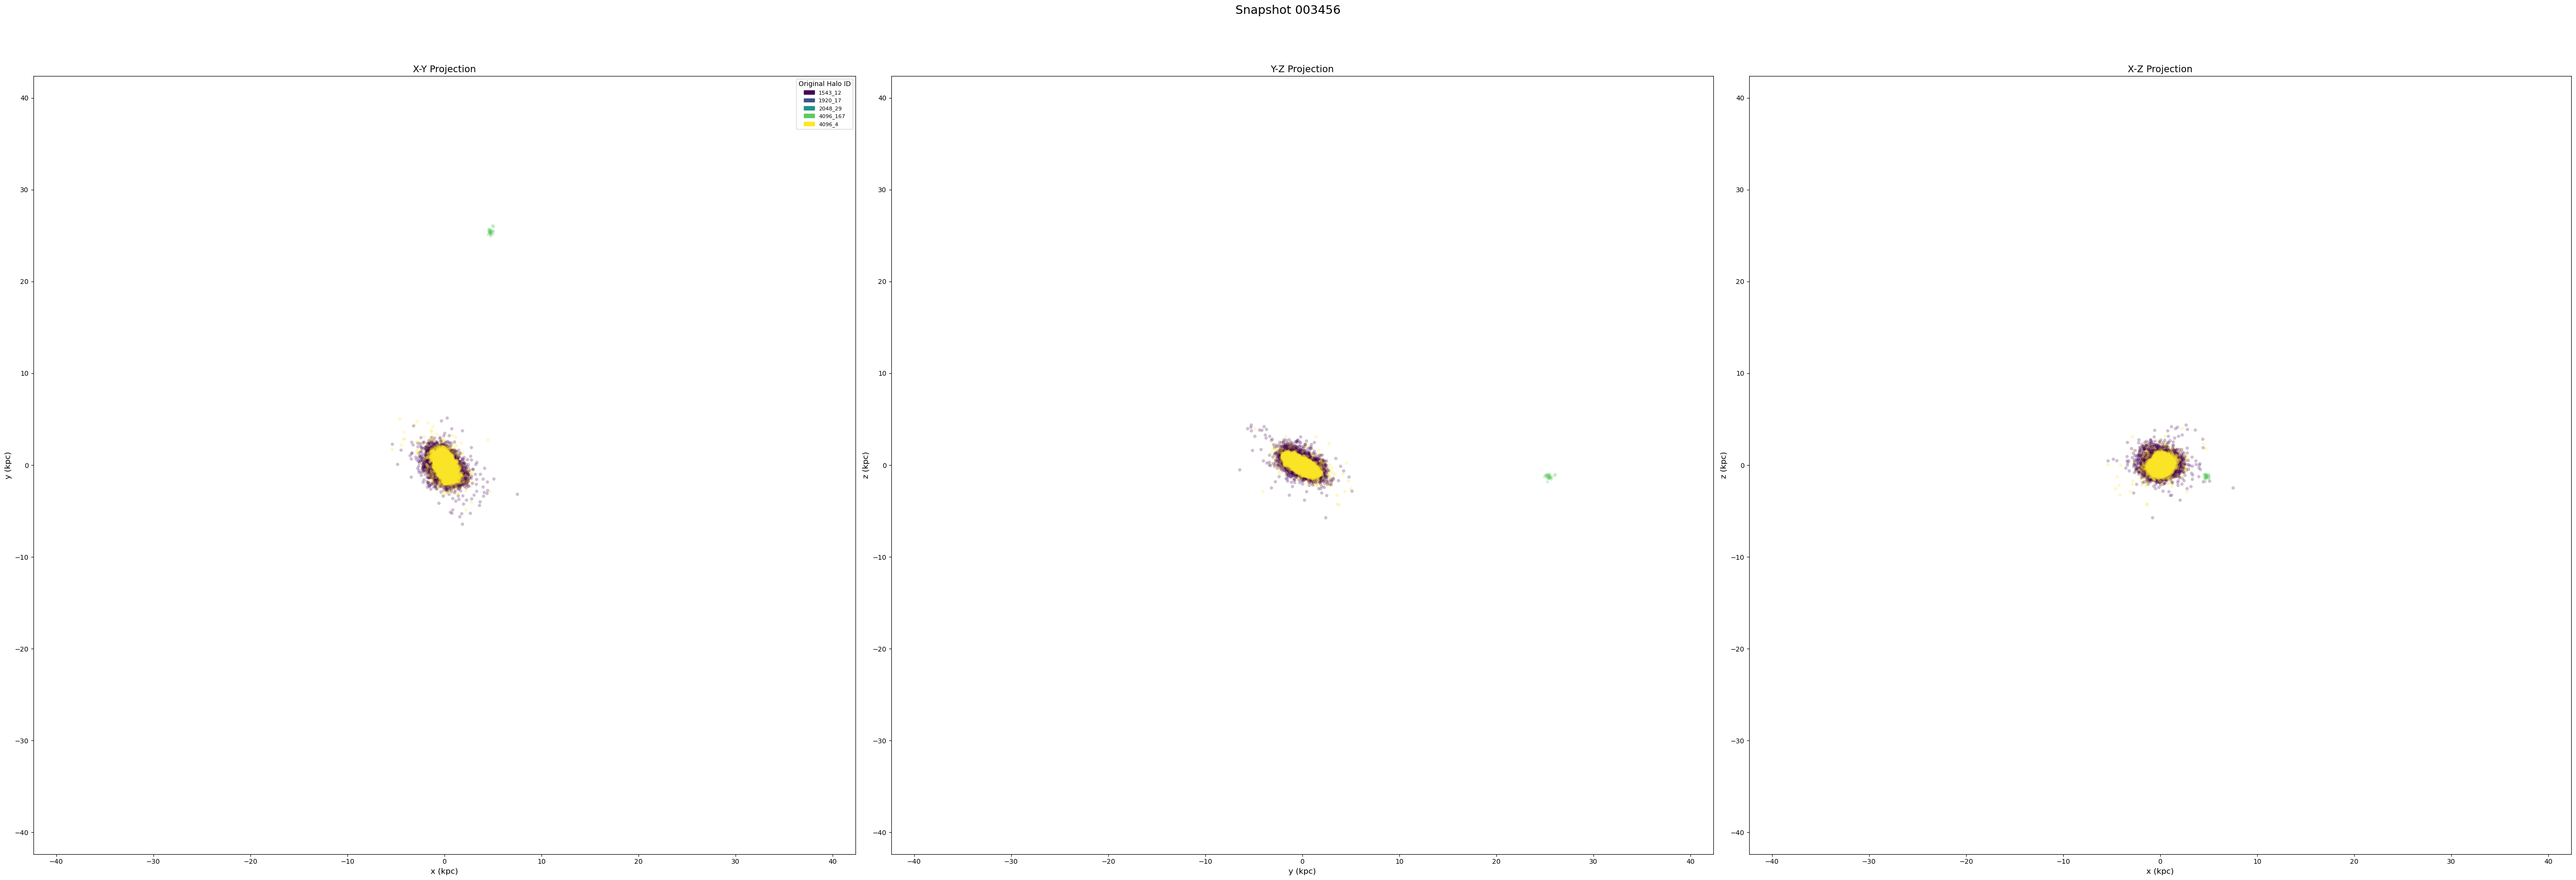

In [157]:
import numpy as np

# Ensure haloids is a numpy array for efficient processing
haloids = np.array(haloids)

# 1. Find the unique halo IDs to create a color mapping
unique_haloids = np.unique(haloids)

# 2. Create a color map that assigns a unique color to each halo ID.
#    Using a qualitative colormap like 'tab20' is good for distinct categories.
num_unique_halos = len(unique_haloids)
# Use a robust colormap that can handle many categories
if num_unique_halos <= 10:
    colors = plt.cm.get_cmap('viridis', num_unique_halos)
else:
    # For more than 20 halos, 'viridis' or 'plasma' can work, though colors may be less distinct
    colors = plt.cm.get_cmap('viridis', num_unique_halos)
    
color_map = {hid: colors(i) for i, hid in enumerate(unique_haloids)}

# 3. Create an array of colors for each star particle
particle_colors = [color_map[hid] for hid in haloids]

# 4. Create the scatter plot
fig, axes = plt.subplots(1, 3, figsize=(54, 18))

# Define projections
projections = [
    {'ax': axes[0], 'dims': [0, 1], 'labels': ['x (kpc)', 'y (kpc)'], 'title': 'X-Y Projection'},
    {'ax': axes[1], 'dims': [1, 2], 'labels': ['y (kpc)', 'z (kpc)'], 'title': 'Y-Z Projection'},
    {'ax': axes[2], 'dims': [0, 2], 'labels': ['x (kpc)', 'z (kpc)'], 'title': 'X-Z Projection'}
]

pos_data = sp.s['pos'][mask]

for proj in projections:
    ax = proj['ax']
    dim1 = proj['dims'][0]
    dim2 = proj['dims'][1]

    ax.scatter(
        pos_data[:, dim1], 
        pos_data[:, dim2],
        c=particle_colors,
        s=25.0,  # Very small marker size for many points
        alpha=0.25, # Use transparency to see overlapping structures
        edgecolors='none' # Remove marker edges for a cleaner look
    )

    ax.set_title(proj['title'], fontsize=14)
    ax.set_xlabel(proj['labels'][0], fontsize=12)
    ax.set_ylabel(proj['labels'][1], fontsize=12)

    if rad:
        ax.set_xlim(-rad, rad)
        ax.set_ylim(-rad, rad)

legend_patches = [mpatches.Patch(color=color_map[hid], label=hid) for hid in unique_haloids]
# Display the legend
if num_unique_halos <= 20:
    axes[0].legend(handles=legend_patches, title="Original Halo ID", loc='upper right', fontsize=8)
else:
    print(f"Warning: {num_unique_halos} unique halos found. Legend will not be displayed to avoid clutter.")

fig.suptitle(f"Snapshot {timestep}", fontsize=18, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
# 6. Set plot titles and labels
# plt.title("Stellar Positions Colored by Original Halo", fontsize=16)
# plt.xlabel("x (kpc)", fontsize=12)
# plt.ylabel("y (kpc)", fontsize=12)
# plt.xlim(-rad, rad)
# plt.ylim(-rad, rad)
# plt.gca().set_aspect('equal', adjustable='box') # Ensure x and y axes have the same scale
# plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
import numpy as np

# Ensure haloids is a numpy array for efficient processing
haloids = np.array(haloids)

# 1. Find the unique halo IDs to create a color mapping
unique_haloids = np.unique(haloids)

# 2. Create a color map that assigns a unique color to each halo ID.
#    Using a qualitative colormap like 'tab20' is good for distinct categories.
num_unique_halos = len(unique_haloids)
# Use a robust colormap that can handle many categories
if num_unique_halos <= 10:
    colors = plt.cm.get_cmap('viridis', num_unique_halos)
else:
    # For more than 20 halos, 'viridis' or 'plasma' can work, though colors may be less distinct
    colors = plt.cm.get_cmap('viridis', num_unique_halos)
    
color_map = {hid: colors(i) for i, hid in enumerate(unique_haloids)}

# 3. Create an array of colors for each star particle
particle_colors = [color_map[hid] for hid in haloids]

# 4. Create the scatter plot
plt.figure(figsize=(18, 18))
plt.scatter(
    sp.s['pos'][mask][:, 0], 
    sp.s['pos'][mask][:, 1],
    c=particle_colors,
    s=25.0,  # Very small marker size for many points
    alpha=0.25, # Use transparency to see overlapping structures
    edgecolors='none' # Remove marker edges for a cleaner look
)

legend_patches = [mpatches.Patch(color=color_map[hid], label=hid) for hid in unique_haloids]
# Display the legend
if num_unique_halos <= 20:
    plt.legend(handles=legend_patches, title="Original Halo ID", loc='upper right', fontsize=8)
else:
    print(f"Warning: {num_unique_halos} unique halos found. Legend will not be displayed to avoid clutter.")

# 6. Set plot titles and labels
plt.title("Stellar Positions Colored by Original Halo", fontsize=16)
plt.xlabel("x (kpc)", fontsize=12)
plt.ylabel("y (kpc)", fontsize=12)
plt.xlim(-rad, rad)
plt.ylim(-rad, rad)
plt.gca().set_aspect('equal', adjustable='box') # Ensure x and y axes have the same scale
# plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

TypeError: ColormapRegistry.get_cmap() takes 2 positional arguments but 3 were given

In [59]:
sp.s.all_keys()

['HII',
 'HeIII',
 'ne',
 'hetot',
 'hydrogen',
 'feh',
 'oxh',
 'ofe',
 'mgfe',
 'nefe',
 'sife',
 'c_s',
 'c_s_turb',
 'mjeans',
 'mjeans_turb',
 'ljeans',
 'ljeans_turb',
 'U_mag',
 'U_lum_den',
 'B_mag',
 'B_lum_den',
 'V_mag',
 'V_lum_den',
 'R_mag',
 'R_lum_den',
 'I_mag',
 'I_lum_den',
 'J_mag',
 'J_lum_den',
 'H_mag',
 'H_lum_den',
 'K_mag',
 'K_lum_den',
 'u_mag',
 'u_lum_den',
 'g_mag',
 'g_lum_den',
 'r_mag',
 'r_lum_den',
 'i_mag',
 'i_lum_den',
 'z_mag',
 'z_lum_den',
 'y_mag',
 'y_lum_den',
 'r',
 'rxy',
 'vr',
 'v2',
 'vt',
 'ke',
 'te',
 'j',
 'j2',
 'jz',
 'vrxy',
 'vcxy',
 'vphi',
 'vtheta',
 'v_mean',
 'v_disp',
 'v_curl',
 'vorticity',
 'v_div',
 'age',
 'theta',
 'alt',
 'az',
 'cs',
 'mu',
 'p',
 'u',
 'temp',
 'zeldovich_offset',
 'aform',
 'tform',
 'iord_argsort',
 'smooth',
 'rho',
 'phi',
 'metals',
 'pos',
 'vel',
 'eps',
 'mass',
 'tform']

/tmp/ipykernel_34615/547441235.py:5: MatplotlibDeprecationWarning: Passing label as a length 205466 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(


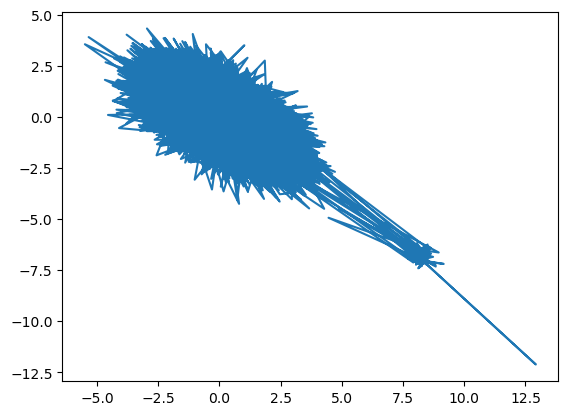

In [56]:
#show the movement of each halo's COM
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.plot(
    sp.s['pos'][:, 0], sp.s['pos'][:, 1],label=haloids)

# fig= plt.figure(figsize=(12,9))
# ax=fig.add_subplot(111, projection='3d')

# ax.plot(sp.s['pos'][:, 0], sp.s['pos'][:, 1], sp.s['pos'][:, 2], label=haloids)

# ax.set_xlabel("x(kpc)")
# ax.set_ylabel("y(kpc)")
# ax.set_zlabel("z(kpc)")

# ax.set_title("Movement of COM")
# ax.legend()
#plt.grid(True)
# plt.savefig('Movement_COM.png')
plt.show()